In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/ML Project - Skin Cancer/train-metadata.csv', low_memory=False)
test_data = pd.read_csv('/content/drive/MyDrive/ML Project - Skin Cancer/test-metadata.csv', low_memory=False)

# Drop useless columns in training metadata

In [4]:
useless_cols = set(train_data.columns) - set(test_data.columns)
useless_cols.remove('target')
useless_cols = list(useless_cols)
train_data = train_data.drop(columns=useless_cols)

In [5]:
useless_cols

['mel_mitotic_index',
 'tbp_lv_dnn_lesion_confidence',
 'iddx_3',
 'iddx_1',
 'iddx_2',
 'iddx_5',
 'mel_thick_mm',
 'iddx_full',
 'lesion_id',
 'iddx_4']

In [6]:
train_size = train_data.shape[0]
train_size

401059

# Extract the target for training

In [7]:
X_train = train_data.drop(columns='target')
y_train = train_data['target']

# Fill absent values

In [8]:
X_train.fillna({'age_approx': X_train['age_approx'].mean(),'anatom_site_general':'NA','sex':'NA'}, inplace=True)

# Combine the test and training set, after normalization will be split again

In [9]:
all_data = pd.concat([X_train, test_data])
all_data.reset_index(drop=True, inplace=True)
all_data.shape[0]

401062

In [ ]:
all_data.dtypes

,0
isic_id,object
patient_id,object
age_approx,float64
sex,object
anatom_site_general,object
clin_size_long_diam_mm,float64
image_type,object
tbp_tile_type,object
tbp_lv_A,float64
tbp_lv_Aext,float64


In [10]:
print(all_data['sex'].dtype)

object


# Drop useless columns in both sets

In [10]:
all_data = all_data.drop(columns=['copyright_license', 'attribution', 'image_type', 'patient_id'])

# Get the names of numeric and categorical columns

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
col_num = []
col_cat = []
for col in all_data:
  if col in ['isic_id']: continue;
  if all_data[col].dtype == 'object':
    col_cat.append(col)
    all_data[col] = all_data[col].astype('category')
  else:
    col_num.append(col)
    all_data[col] = all_data[col].astype('float64')

# Normalization for numeric columns

In [12]:
# Normalization for numeric values
numeric_transformer = StandardScaler()
all_data.loc[:,col_num] = numeric_transformer.fit_transform(all_data[col_num])

# One hot encoding for categorical columns.

In [13]:
categorical_transformer = OneHotEncoder(sparse_output=False)
X_cat = categorical_transformer.fit_transform(all_data[col_cat])
new_cat_col = categorical_transformer.get_feature_names_out(col_cat)

In [14]:
all_data = all_data.drop(columns=col_cat)

In [15]:
all_data = pd.concat([all_data,pd.DataFrame(X_cat, columns=new_cat_col)],axis=1)

# Return the data to test and training set

In [16]:
X_train = all_data.iloc[0:train_size,:]
X_test = all_data.iloc[train_size:,:]

In [17]:
X_test.reset_index(drop=True, inplace=True)

# Take out the id for test and training set

In [18]:
col_id = ['isic_id']
X_train_id = X_train[col_id]
X_train_data = X_train.drop(columns=col_id)
X_test_id = X_test[col_id]
X_test_data = X_test.drop(columns=col_id)

# Some statistics

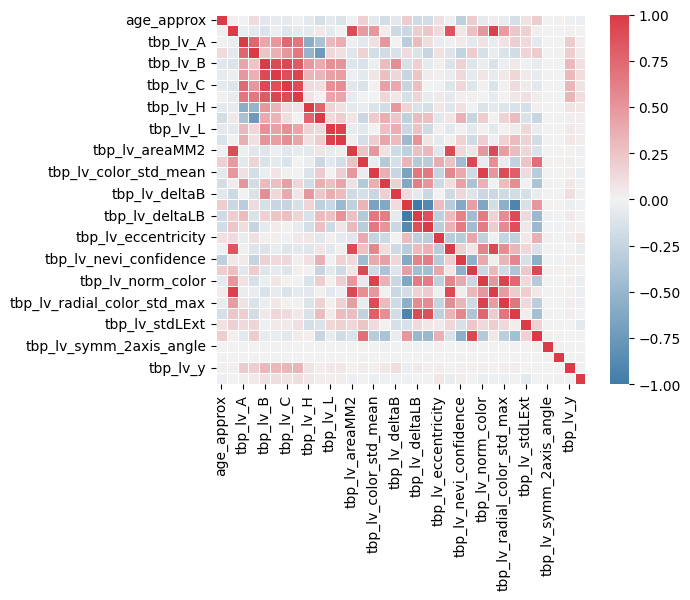

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

data_updated = X_train[col_num]
correlation= data_updated.corr()

# axis_corr = sns.heatmap(
#   correlation,
#   vmin=-1, vmax=1, center=0,
#   cmap=sns.diverging_palette(100, 500, n=500, as_cmap=True),
#   square=True
# )

axis_corr = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(240, 10, n=500, as_cmap=True),  # Blue to red diverging palette
    square=True,
    linewidths=0.5,  # Optional: spacing between cells
)

plt.show()



In [ ]:
type(correlation)

pandas.core.frame.DataFrame

In [21]:
high_corr = correlation.where(np.abs(correlation) > 0.85).stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
high_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Display the result
high_corr

,Feature 1,Feature 2,Correlation
2,clin_size_long_diam_mm,tbp_lv_areaMM2,0.902768
3,clin_size_long_diam_mm,tbp_lv_minorAxisMM,0.858842
4,clin_size_long_diam_mm,tbp_lv_perimeterMM,0.965004
8,tbp_lv_B,tbp_lv_Bext,0.909632
9,tbp_lv_B,tbp_lv_C,0.920575
10,tbp_lv_Bext,tbp_lv_B,0.909632
12,tbp_lv_Bext,tbp_lv_C,0.885437
13,tbp_lv_Bext,tbp_lv_Cext,0.939995
14,tbp_lv_C,tbp_lv_B,0.920575
15,tbp_lv_C,tbp_lv_Bext,0.885437


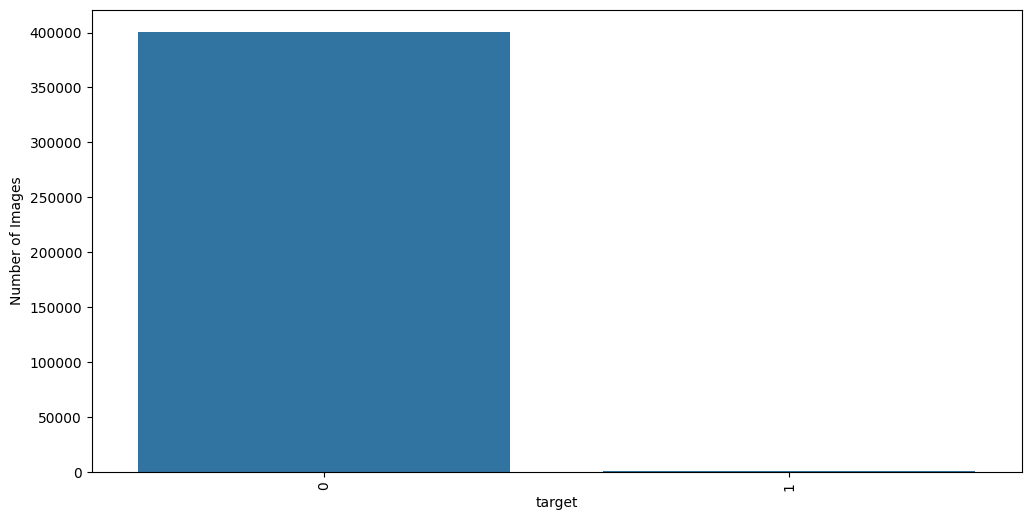

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='target', data=train_data)
plt.xlabel('target')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

# The score function

In [20]:
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC

    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC)
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''

    # del solution[row_id_column_name]
    # del submission[row_id_column_name]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)

    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return(partial_auc)

# Split the training set into training and validation set

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
X_train_data_partial, X_val, y_train_partial, y_val = train_test_split(X_train_data, y_train, test_size=0.2, stratify=y_train)
model_names = []
scores = []

# This part we will try several naive models

In [22]:
n_est = 100
model1 = ExtraTreesClassifier(n_estimators=n_est, criterion='log_loss')
model2 = RandomForestClassifier(n_estimators=n_est, criterion='log_loss')

In [23]:
model1.fit(X_train_data_partial, y_train_partial)
model2.fit(X_train_data_partial, y_train_partial)

RandomForestClassifier(criterion='log_loss')

In [24]:
predictions1 = model1.predict_proba(X_val)[:,1]
predictions2 = model2.predict_proba(X_val)[:,1]

In [ ]:
# No need to run this cell, it should be in kaggle notebook
submission = pd.DataFrame(
    {'isic_id': X_test['isic_id'], 'target': predictions},
    columns = ['isic_id', 'target'])
submission.to_csv('submission.csv', index = False)

NameError: name 'predictions' is not defined

In [25]:
sc = score(pd.DataFrame(y_val), pd.DataFrame(predictions1),'isic_id')
model_names.append('Extra Tree')
scores.append(sc)
print(sc)

0.053315363208665575


In [26]:
sc = score(pd.DataFrame(y_val), pd.DataFrame(predictions2),'isic_id')
model_names.append('Random Forest')
scores.append(sc)
print(sc)

0.04404826975153805


In [27]:
# Extra Tree with SMOTE
model3 = ExtraTreesClassifier(n_estimators=n_est)
X_resampled, y_resampled = SMOTE().fit_resample(X_train_data_partial, y_train_partial)
model3.fit(X_resampled, y_resampled)
predictions3 = model3.predict_proba(X_val)[:,1]
sc = score(pd.DataFrame(y_val), pd.DataFrame(predictions3),'isic_id')
model_names.append('Extra Tree with SMOTE')
scores.append(sc)
print(sc)

0.077153482335617


In [ ]:
len(list(X_train_data_partial.columns))

74

In [ ]:
# PCA processed data for later useage
pca = PCA(n_components=41)
X_pca_train = pca.fit_transform(X_train_data_partial)
X_pca_val = pca.transform(X_val)

In [ ]:
# Extra Tree with SMOTE and PCA
model4 = ExtraTreesClassifier(n_estimators=n_est)
X_resampled_pca, y_resampled_pca = SMOTE().fit_resample(X_pca_train, y_train_partial)
model4.fit(X_resampled_pca, y_resampled_pca)
predictions4 = model4.predict_proba(X_pca_val)[:,1]
sc = score(pd.DataFrame(y_val), pd.DataFrame(predictions4),'isic_id')
model_names.append('Extra Tree with SMOTE and PCA')
scores.append(sc)
print(sc)

0.11836692700916368


In [ ]:
# ADASYN resampled data for later useage
X_clresampled_pca, y_clresampled_pca = ADASYN().fit_resample(X_pca_train, y_train_partial)

In [ ]:
# Extra Tree with ADASYN and PCA
model5 = ExtraTreesClassifier(n_estimators=n_est)
model5.fit(X_clresampled_pca, y_clresampled_pca)
predictions5 = model5.predict_proba(X_pca_val)[:,1]
sc = score(pd.DataFrame(y_val), pd.DataFrame(predictions5),'isic_id')
model_names.append('Extra Tree with ADASYN and PCA')
scores.append(sc)
print(sc)

0.11979489794419304


# This part we will use dropout.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization
from tensorflow.keras.activations import swish, elu
from tensorflow.keras.optimizers import Adam

pca = PCA(n_components=41)
X_pca_train = pca.fit_transform(X_train_data_partial)
X_pca_val = pca.transform(X_val)
# Resplit the training data for drop out model before resample
X_train_dp, X_val_dp, y_train_dp, y_val_dp = train_test_split(X_pca_train, y_train_partial, test_size=0.2, stratify=y_train_partial)
# Validation data for epoch training
y_val_dp_one_hot = pd.get_dummies(y_val_dp, dtype=int)
validation_set_dp = (X_val_dp, y_val_dp_one_hot)

# Dropout with ADASYN and PCA
X_resampled_dp, y_resampled_dp = ADASYN().fit_resample(X_train_dp, y_train_dp)
# One hot encode y for loss='categorical_crossentropy'
y_resampled_one_hot = pd.get_dummies(y_resampled_dp, dtype=int)
def build_model(input_shape):
    x = Input(shape=input_shape)
    d1 = Dropout(rate=0.1)(x)
    h1 = Dense(8)(d1)
    a1 = Activation(swish)(h1)
    b1 = BatchNormalization()(a1)
    d2 = Dropout(rate=0.5)(b1)
    h2 = Dense(4)(d2)
    a2 = Activation(elu)(h2)
    b2 = BatchNormalization()(a2)
    d3 = Dropout(rate=0.5)(b2)
    h3 = Dense(2)(d3)
    a3 = Activation(swish)(h3)
    b3 = BatchNormalization()(a3)
    d4 = Dropout(rate=0.5)(b3)
    h4 = Dense(2)(d4)
    p = Activation('softmax')(h4)
    model = Model(inputs=x, outputs=p)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model6 = build_model((X_resampled_dp.shape[1],))

In [ ]:
y_resampled_one_hot.head()

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [ ]:
# Train the model
model6.fit(X_resampled_dp, y_resampled_one_hot, epochs=10, batch_size=64, validation_data=validation_set_dp)

Epoch 1/10
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.6294 - loss: 0.6549 - val_accuracy: 0.8718 - val_loss: 0.3299
Epoch 2/10
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7468 - loss: 0.4849 - val_accuracy: 0.8717 - val_loss: 0.3218
Epoch 3/10
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7528 - loss: 0.4726 - val_accuracy: 0.8869 - val_loss: 0.3027
Epoch 4/10
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.7544 - loss: 0.4683 - val_accuracy: 0.8928 - val_loss: 0.2862
Epoch 5/10
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7542 - loss: 0.4695 - val_accuracy: 0.8985 - val_loss: 0.2772
Epoch 6/10
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7533 - loss: 0.4684 - val_accuracy: 0.8958 - val_loss: 0.2836
Epoch 7/10
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7542 - loss: 0.4663 - val_accuracy: 0.8939 - val_loss: 0.2867
Epoch 8/10
8013/8013 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7563 - loss: 0

In [ ]:
predictions6 = model6.predict(X_pca_val)[:,1]
sc = score(pd.DataFrame(y_val), pd.DataFrame(predictions6),'isic_id')
model_names.append('Dropout with ADASYN and PCA')
scores.append(sc)
print(sc)

2507/2507 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
0.1530543762134691


# Model using XGBoost

In [24]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


neg, pos = np.bincount(y_train_partial)
scale_pos_weight = neg/pos
xgb_ml = xgb.XGBClassifier(
            scale_pos_weight=scale_pos_weight,  # Handle class imbalance
            learning_rate=0.01,
            n_estimators=200,
            max_depth=3,
            min_child_weight=4,
            gamma=1,
            subsample=0.75,
            colsample_bytree=0.75,
            random_state=42,
            eval_metric=['logloss','aucpr']  # Use appropriate metric for binary classification
        )

In [25]:
xgb_ml.fit(X_train_data_partial, y_train_partial)
predictions7 = xgb_ml.predict_proba(X_val)[:, 1]
sc = score(pd.DataFrame(y_val), pd.DataFrame(predictions7),'isic_id')
model_names.append('XGBoost')
scores.append(sc)
print(sc)

0.15014898490752793


In [27]:
# PCA processed data for later useage
pca = PCA(n_components=41)
X_pca_train = pca.fit_transform(X_train_data_partial)
X_pca_val = pca.transform(X_val)

In [33]:
xgb_ml.fit(X_pca_train, y_train_partial)
predictions7 = xgb_ml.predict_proba(X_pca_val)[:, 1]
score(pd.DataFrame(y_val), pd.DataFrame(predictions7),'isic_id')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:46:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


0.11787965798000062

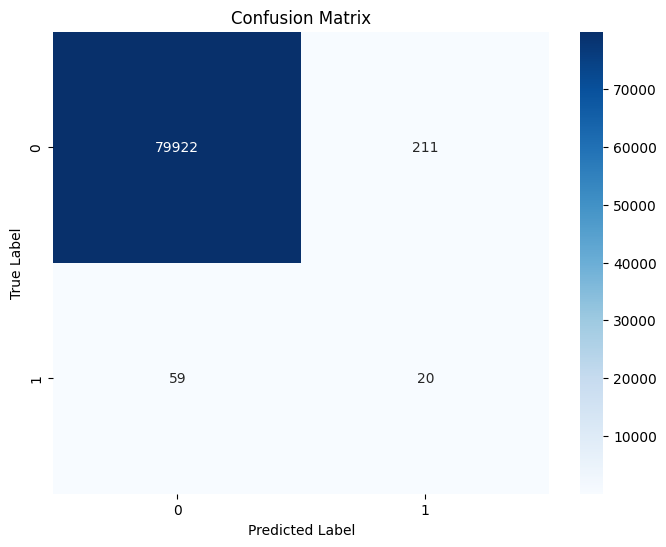

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, xgb_ml.predict(X_val))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

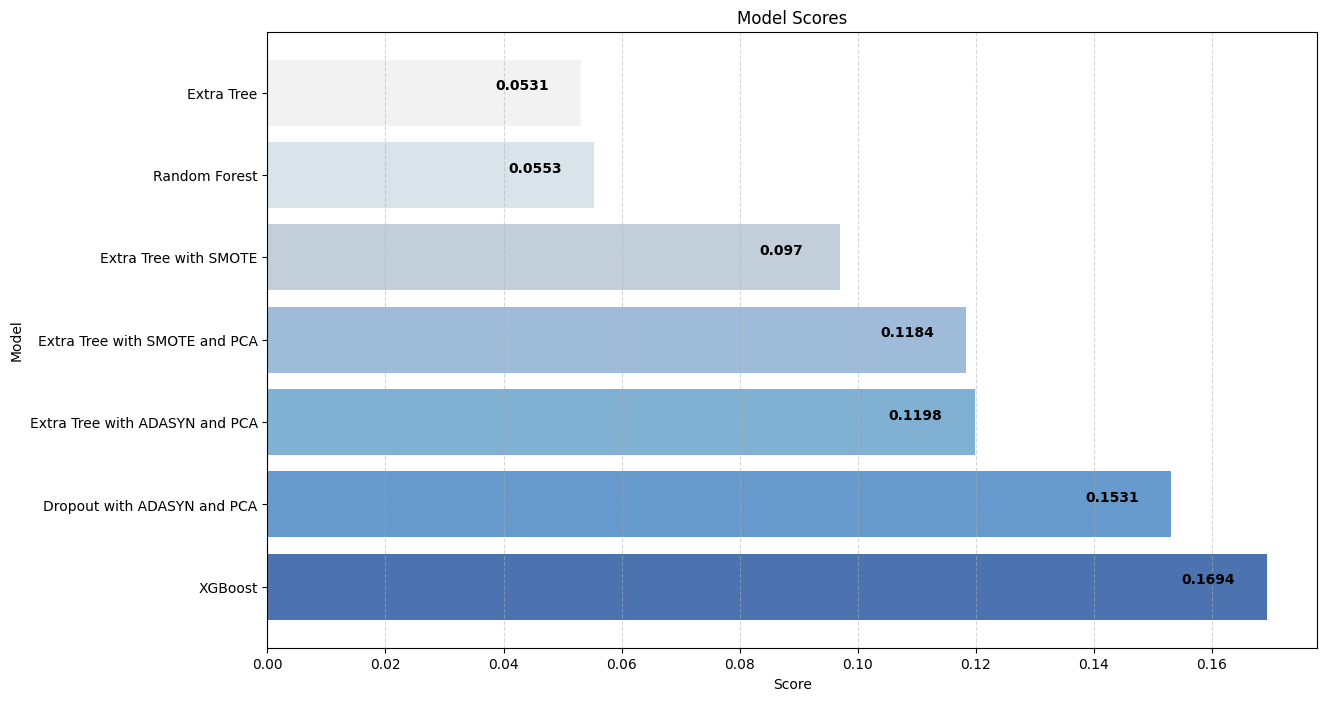

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

scores = list(map(lambda x: round(x, 4), scores))
# Create the bars with blue-toned colors
colors = ['#4c72b0', '#6699cc', '#80b1d3', '#9ebcda', '#c2ced9', '#d8e4e9', '#f2f2f2'][::-1]
ax.barh(model_names, scores, color=colors)

# Add labels and title
ax.set_ylabel('Model')
ax.set_xlabel('Score')
ax.set_title('Model Scores')

# Add grid lines
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Customize the x-axis ticks
ax.set_yticks(range(len(model_names)))
ax.set_yticklabels(model_names, ha='right')

# Add value labels on top of the bars
for i, v in enumerate(scores):
    ax.text(v-0.01, i, str(v), ha='center', va='bottom', fontweight='bold')

# Adjust the spacing
plt.subplots_adjust(left=0.2)

ax.invert_yaxis()

# Display the plot
plt.show()

# CV

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# classification_report(y_val, xgb_ml.predict(X_val))
# cross_val_score(xgb_ml, X_train_data, y_train, cv=5, scoring='roc_auc')
def remove_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis=1)

In [35]:
cross_val_score(xgb_ml, X_train_data, y_train, cv=5, scoring='roc_auc')

array([0.93768243, 0.92134027, 0.91549081, 0.95545444, 0.93723976])